In [13]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import ttest_ind

tickers = ["AAPL", "GOOGL", "META", "AMZN", "MSFT"]
summary_results = []

for ticker in tickers:
    print(f"▶ 分析中: {ticker}")
    try:
        # データ読み込み
        df = pd.read_csv(f"../data/{ticker}_news_with_sentiment.csv")
        df['date'] = pd.to_datetime(df['datetime']).dt.strftime('%Y-%m-%d')
        sentiment_daily = df.groupby('date')['sentiment_score'].mean().reset_index()
        sentiment_daily.rename(columns={'date': 'Date', 'sentiment_score': 'SentimentScore'}, inplace=True)

        # 株価取得
        end_date = datetime.today()
        start_date = end_date - timedelta(days=90)
        stock = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        if isinstance(stock.columns, pd.MultiIndex):
            stock.columns = stock.columns.get_level_values(0)

        # ✅ 終値と日付だけ抽出・整形（階層を潰す）
        stock = stock[['Close']].reset_index()
        stock.columns = ['Date', 'Close']  # カラム名を1段に
        stock['Date'] = pd.to_datetime(stock['Date']).dt.strftime('%Y-%m-%d')

        # マージとリターン
        merged = pd.merge(stock, sentiment_daily, on='Date', how='inner')
        merged['NextClose'] = merged['Close'].shift(-1)
        merged['Return1d'] = (merged['NextClose'] - merged['Close']) / merged['Close']

        # t検定と相関
        pos = merged[merged['SentimentScore'] > 0]['Return1d'].dropna()
        neg = merged[merged['SentimentScore'] < 0]['Return1d'].dropna()
        t_stat, p_value = ttest_ind(pos, neg, equal_var=False)
        corr = merged[['SentimentScore', 'Return1d']].corr().iloc[0, 1]

        # 感情スコア付きの元データ（1記事ごと）
        df = pd.read_csv(f"../data/{ticker}_news_with_sentiment.csv")

        # 🆕 全記事数
        num_articles = len(df)

        # 🆕 感情別の記事数（positive, negative, neutral）
        n_positive_articles = (df['sentiment_score'] > 0).sum()
        n_negative_articles = (df['sentiment_score'] < 0).sum()
        n_neutral_articles = (df['sentiment_score'] == 0).sum()


        summary_results.append({
            'Ticker': ticker,
            'N_Pos': len(pos),  # 株価リターン付きの「日数」ベース
            'N_Neg': len(neg),
            'Article_Pos': n_positive_articles,  # 🆕 ポジティブ記事数
            'Article_Neg': n_negative_articles,  # 🆕 ネガティブ記事数
            'Article_Neutral': n_neutral_articles,
            'Total_Articles': num_articles,
            'Mean_Pos': pos.mean(),
            'Mean_Neg': neg.mean(),
            'T_Stat': t_stat,
            'P_Value': p_value,
            'Correlation': corr
        })
    except Exception as e:
        print(f"An error has occured: {ticker} → {e}")

summary_df = pd.DataFrame(summary_results)
summary_df

▶ 分析中: AAPL


[*********************100%***********************]  1 of 1 completed


▶ 分析中: GOOGL


[*********************100%***********************]  1 of 1 completed
/Users/pretz/dev/blackrock-news-sentiment/.venv/lib/python3.12/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


▶ 分析中: META


[*********************100%***********************]  1 of 1 completed


▶ 分析中: AMZN


[*********************100%***********************]  1 of 1 completed


▶ 分析中: MSFT


[*********************100%***********************]  1 of 1 completed


,Ticker,N_Pos,N_Neg,Article_Pos,Article_Neg,Article_Neutral,Total_Articles,Mean_Pos,Mean_Neg,T_Stat,P_Value,Correlation
0,AAPL,4,2,558,256,257,1071,0.016174,0.003004,0.761357,0.490187,0.768888
1,GOOGL,7,0,546,241,248,1035,0.013579,NaN,NaN,NaN,0.176541
2,META,7,2,564,253,223,1040,0.012669,-0.009201,1.150870,0.336973,0.316031
3,AMZN,6,1,583,277,200,1060,0.020068,0.013085,NaN,NaN,0.353154
4,MSFT,6,2,567,301,206,1074,0.002833,0.016231,-1.683517,0.324143,-0.488147


<Axes: title={'center': 'Correlation (Sentiment vs Return)'}, ylabel='Ticker'>

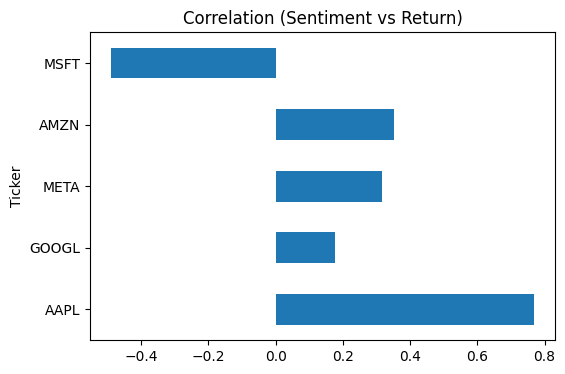

In [14]:
summary_df[["Ticker", "Correlation"]].set_index("Ticker").plot.barh(figsize=(6,4), legend=False, title="Correlation (Sentiment vs Return)")